In [1]:
import numpy as np
from astropy.io import fits
from astropy.table import Table as Table
import matplotlib.pyplot as plt
from linetools.spectra import utils as ltsu
from linetools.spectra.xspectrum1d import XSpectrum1D
import astropy.units as u
from astropy import constants as const
from numpy import random as ran
%matplotlib inline

In [2]:
#to order and match the spec with their z values
spec_atr_16 = Table.read('/home/jsm/PycharmProjects/Summer_Research_2018/old_spec/spec_atr.txt', format = 'ascii') 

#an initial filter to ensure the spec included cover lya
basestring_16 = '/home/jsm/PycharmProjects/Summer_Research_2018/old_spec/'

init_spec_16 = []

init_z_16 = []
    
for entry in spec_atr_16:
    
    if 2.00 < entry["zspec"] < 2.5: 
        
        temp = XSpectrum1D.from_file(basestring_16 + entry["Filename"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["zspec"]) < temp.wvmax:
                
            init_z_16.append(entry["zspec"])
                
            init_spec_16.append(XSpectrum1D.from_file(basestring_16 + entry["Filename"]))

In [3]:
#to order and match the spec with their z values
spec_atr_17 = Table.read('/home/jsm/PycharmProjects/Summer_Research_2018/new_spec/cl2017_redux/cl2017_valueadded_release_20171009.txt',
                         format = 'ascii') 

#an initial filter to ensure the spec included cover lya
basestring_17 = '/home/jsm/PycharmProjects/Summer_Research_2018/new_spec/cl2017_redux/spec_v0/'

init_spec_17 = []

init_z_17 = []
    
for entry in spec_atr_17:
    
    if 2.00 < entry["col5"] < 2.5: 
        
        temp = XSpectrum1D.from_file(basestring_17 + entry["col1"])
        
        if temp.wvmin < (1216*u.AA)*(1+entry["col5"]) < temp.wvmax:
                
            init_z_17.append(entry["col5"])
                
            init_spec_17.append(XSpectrum1D.from_file(basestring_17 + entry["col1"]))

/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [4]:
speclist = np.asarray(init_spec_16 + init_spec_17)

print("Number of spectra (Nspec) after filter =", len(speclist))

z_val = np.asarray(init_z_16 + init_z_17)

Number of spectra (Nspec) after filter = 285


In [5]:
r_1 = range(len(speclist))

temp_1 = [np.asarray(speclist[i].wavelength/(1+z_val[i])) for i in r_1]

wv_coverage = [ (1050 >= min(wave)) & (1550 <= max(wave)) for wave in temp_1]

g_spec = speclist[wv_coverage]

gz = z_val[wv_coverage]

In [6]:
# the normalization

r_2  = range(len(g_spec))

temp_2 = [np.asarray(g_spec[i].wavelength/(1+gz[i])) for i in r_2]

wv_norm = [ (1445 < entry) & (entry < 1455) for entry in temp_2 ]

rough_med = np.asarray([np.median(g_spec[i].flux[wv_norm[i]]) for i in r_2])

g_med = [median > 0.0 for median in rough_med]

medians = rough_med[g_med]

b_spec = g_spec[g_med]

bz= gz[g_med]

r_3 = range(len(b_spec))

norm_flux = np.asarray([(b_spec[i].flux/medians[i]) for i in r_3])

In [7]:
#the new scaled Xspec objects

scaled_spec = []

for i in r_3:       
    
    scaled_spec.append(XSpectrum1D(b_spec[i].wavelength,norm_flux[i],sig=b_spec[i].sig))

/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/linetools-0.3.dev2065-py3.5.egg/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [8]:
#the first trim on the wavelegth array to ensure a solid stack
trim_spec = []

for i in range(len(scaled_spec)):       
    
    trim_spec.append(XSpectrum1D(scaled_spec[i].data["wave"][0][440:1500],
                                 scaled_spec[i].data["flux"][0][440:1500],
                                 scaled_spec[i].data["sig"][0][440:1500]))

/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/linetools-0.3.dev2065-py3.5.egg/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


In [9]:
collate = ltsu.collate(trim_spec)

rest_spec = ltsu.rebin_to_rest(collate,bz, 200*u.km/u.s,grow_bad_sig = True)

stack = ltsu.smash_spectra(rest_spec)

size = collate.nspec

In [47]:
R = (len(trim_spec))

M = len(trim_spec[0].flux)

N = 10000

In [49]:
import time
start = time.time()

N_stack = []

for i in np.arange(N):
    
    choice = np.asarray(ran.randint(0,size,size))

    rand_spec = np.asarray([rest_spec[index] for index in choice])

    rand_collate = ltsu.collate(rand_spec)

    N_stack.append(ltsu.smash_spectra(rand_collate))


end = time.time()
print(end - start)

5495.416362285614


In [50]:
N_flux = np.array([entry.flux for entry in N_stack])


N_matrix = np.array([N_flux[i] - stack.flux for i in range(N)])

In [51]:
tranpose =  np.transpose(N_matrix)

In [52]:
#look up the covarience definition. transpose the matrix and dot it with its transpose.
#divide the diagnol of the dot by N-1 and take the sqrt 

In [53]:
covariance = np.dot(tranpose,N_matrix)

sigma = np.sqrt(np.diagonal(covariance)/(N-1))

In [54]:
sigma.shape

(821,)

In [62]:
sigma

AttributeError: module 'numpy' has no attribute 'type'

In [64]:
print(len(stack.flux))
print(len(stack.wavelength))
print(len(sigma))

821
821
821


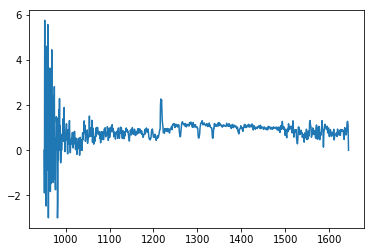

In [63]:
plt.plot(stack.wavelength,stack.flux)
plt.show()

In [65]:
composite = XSpectrum1D(stack.wavelength,stack.flux,sig=sigma)

/home/jsm/.pyenv/versions/anaconda3-2.4.1/lib/python3.5/site-packages/linetools-0.3.dev2065-py3.5.egg/linetools/spectra/xspectrum1d.py:254: UserWarning: No unit given to wavelength, assuming Angstroms.
  warnings.warn("No unit given to wavelength, assuming Angstroms.")


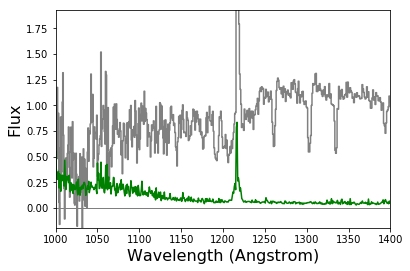

In [67]:
composite.plot(xlim=(1000,1400))

In [68]:
composite.write_to_fits("LBG_stack-z<2.5.fits")

Wrote spectrum to LBG_stack-z<2.5.fits
